## Importieren der notwendigen Bibliotheken

In [307]:
# Installieren zusätzlicher Pakete (falls benötigt)
# !pip install shap
# !pip install kagglehub
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Einlesen des Datensatzes
df = pd.read_csv("car details v4.csv")

In [308]:
df

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,Mahindra,XUV500 W8 [2015-2017],850000,2016,90300,Diesel,Manual,Surat,White,First,Individual,2179 cc,138 bhp @ 3750 rpm,330 Nm @ 1600 rpm,FWD,4585.0,1890.0,1785.0,7.0,70.0
2055,Hyundai,Eon D-Lite +,275000,2014,83000,Petrol,Manual,Ahmedabad,White,Second,Individual,814 cc,55 bhp @ 5500 rpm,75 Nm @ 4000 rpm,FWD,3495.0,1550.0,1500.0,5.0,32.0
2056,Ford,Figo Duratec Petrol ZXI 1.2,240000,2013,73000,Petrol,Manual,Thane,Silver,First,Individual,1196 cc,70 bhp @ 6250 rpm,102 Nm @ 4000 rpm,FWD,3795.0,1680.0,1427.0,5.0,45.0
2057,BMW,5-Series 520d Luxury Line [2017-2019],4290000,2018,60474,Diesel,Automatic,Coimbatore,White,First,Individual,1995 cc,188 bhp @ 4000 rpm,400 Nm @ 1750 rpm,RWD,4936.0,1868.0,1479.0,5.0,65.0


Extrahieren von numerischen Werten aus den Spalten 'Max Power' und 'Max Torque'

In [309]:
df[['Max Power Value', 'Max Power RPM']] = df['Max Power'].str.extract(r'(\d+)\D*(\d+)')
df[['Max Torque Value', 'Max Torque RPM']] = df['Max Torque'].str.extract(r'(\d+)\D*(\d+)')

Extrahieren der Hubraumangabe aus der 'Engine'-Spalte

In [310]:
df['Engine Capacity'] = df['Engine'].str.split(" ", expand=True).iloc[:, 0]

Erstellen einer neuen Spalte, die das Alter des Autos beschreibt (je neuer, desto wertvoller)

In [311]:
max_year = df['Year'].max()
df['Car exploitet in years'] = max_year - df['Year']

Umwandeln der extrahierten Strings in numerische Werte

In [312]:
df['Max Power Value'] = pd.to_numeric(df['Max Power Value'])
df['Max Power RPM'] = pd.to_numeric(df['Max Power RPM'])
df['Max Torque Value'] = pd.to_numeric(df['Max Torque Value'])
df['Max Torque RPM'] = pd.to_numeric(df['Max Torque RPM'])

Drop all changed columns

In [313]:
df = df.drop(columns=['Max Power', 'Max Torque', 'Engine', 'Year'])

Entferne Objekt-Spalten mit zu vielen eindeutigen Werten (z. B. Freitext wie Modellbezeichnungen)
Diese sind meist schwer zu verarbeiten und wenig hilfreich für das Modell

In [314]:
# Collect columns to drop
columns_to_drop = []

# Loop through columns to check their type and unique values
for i in df.columns:
    if df[i].dtype == 'object' and len(df[i].unique()) > 50:
        columns_to_drop.append(i)

# Drop the identified columns
df = df.drop(columns=columns_to_drop)

## Overview on how table has changed

In [315]:
df

,Make,Price,Kilometer,Fuel Type,Transmission,Color,Owner,Seller Type,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,Max Power Value,Max Power RPM,Max Torque Value,Max Torque RPM,Car exploitet in years
0,Honda,505000,87150,Petrol,Manual,Grey,First,Corporate,FWD,3990.0,1680.0,1505.0,5.0,35.0,87.0,6000.0,109.0,4500.0,5
1,Maruti Suzuki,450000,75000,Diesel,Manual,White,Second,Individual,FWD,3995.0,1695.0,1555.0,5.0,42.0,74.0,4000.0,190.0,2000.0,8
2,Hyundai,220000,67000,Petrol,Manual,Maroon,First,Individual,FWD,3585.0,1595.0,1550.0,5.0,35.0,79.0,6000.0,112.0,7619.0,11
3,Toyota,799000,37500,Petrol,Manual,Red,First,Individual,FWD,3995.0,1745.0,1510.0,5.0,37.0,82.0,6000.0,113.0,4200.0,3
4,Toyota,1950000,69000,Diesel,Manual,Grey,First,Individual,RWD,4735.0,1830.0,1795.0,7.0,55.0,148.0,3400.0,343.0,1400.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,Mahindra,850000,90300,Diesel,Manual,White,First,Individual,FWD,4585.0,1890.0,1785.0,7.0,70.0,138.0,3750.0,330.0,1600.0,6
2055,Hyundai,275000,83000,Petrol,Manual,White,Second,Individual,FWD,3495.0,1550.0,1500.0,5.0,32.0,55.0,5500.0,75.0,4000.0,8
2056,Ford,240000,73000,Petrol,Manual,Silver,First,Individual,FWD,3795.0,1680.0,1427.0,5.0,45.0,70.0,6250.0,102.0,4000.0,9
2057,BMW,4290000,60474,Diesel,Automatic,White,First,Individual,RWD,4936.0,1868.0,1479.0,5.0,65.0,188.0,4000.0,400.0,1750.0,4


Identifying object and numeric columns

In [316]:
object_columns = []
numeric_columns = []

for i in df.columns:
    if df[i].dtype == 'object':
        object_columns.append(i)
    else:
        numeric_columns.append(i)

Fill missing values with most occuring string

In [317]:
for col in df.select_dtypes(include=['object']).columns:
    most_frequent_value = df[col].mode()[0]  # Get the most frequent value
    df[col].fillna(most_frequent_value, inplace=True)

Fill missing values for numeric columns with the average value (mean)

In [318]:
for col in df.select_dtypes(include=['number']).columns:
    mean_value = df[col].mean()  # Get the mean value
    df[col].fillna(mean_value, inplace=True)

Input output

In [319]:
y = df["Price"]
X = df.drop(columns=["Price"])

First we train without our string feautures

In [320]:
X = X.drop(columns=object_columns)

## Modellvergleich: Lineare Regression, Lasso und Logistische Regression

In diesem Abschnitt vergleichen wir die Modelle **Lineare Regression**, **Lasso** und **Logistische Regression**.
Obwohl die **Logistische Regression** eigentlich für Klassifikationsprobleme gedacht ist, zeigen wir hier exemplarisch, wie sie sich bei einer Preisvorhersage verhält – auch wenn sie methodisch nicht ideal ist.


Model: LinearRegression
Average R² score on training set: 0.6665625400898865 ± 0.013493388094843267
Average R² score on test set: 0.6509093641868238 ± 0.061456243891206075

Model: LogisticRegression
Average R² score on training set: 0.17263511164669104 ± 0.08969069171501731
Average R² score on test set: 0.15924237242781597 ± 0.09018961926224281

Model: Lasso
Average R² score on training set: 0.6665625400806466 ± 0.013493388092812662
Average R² score on test set: 0.6509097608315882 ± 0.061456060150388944



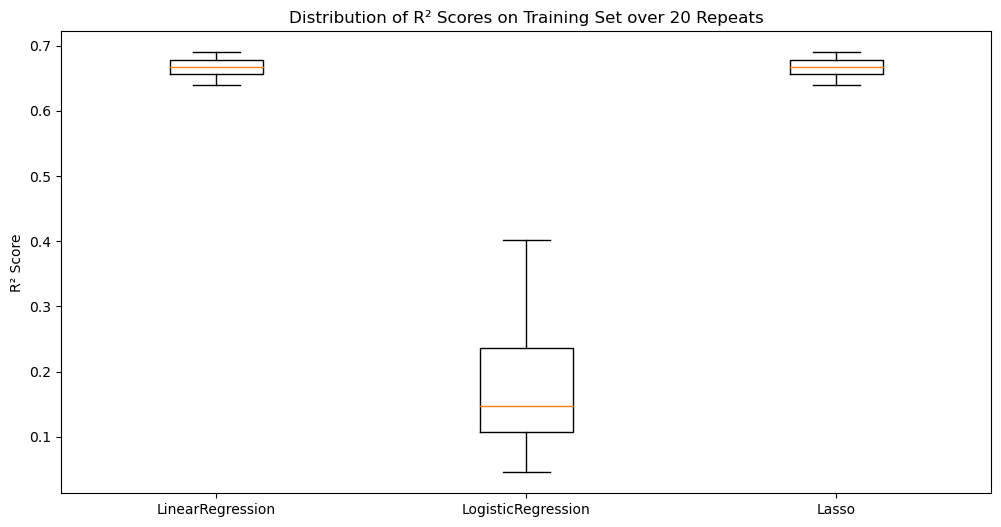

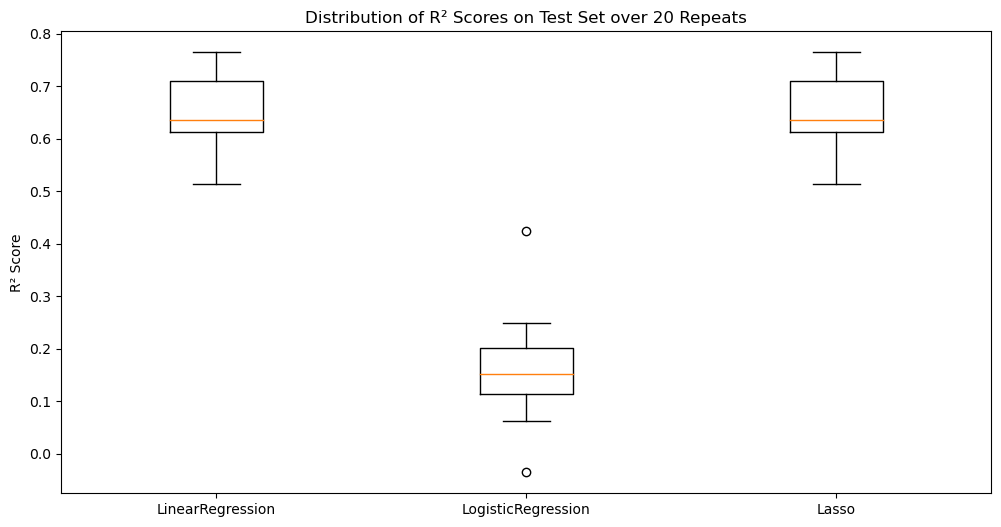

In [321]:
# Initialize dictionaries to store R² scores for train and test datasets
r2_train_scores = {"LinearRegression": [], "LogisticRegression": [], "Lasso": []}
r2_test_scores = {"LinearRegression": [], "LogisticRegression": [], "Lasso": []}

# Repeat the process 20 times with different splits
for i in range(20):
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Standardize the data using MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on X_train and apply it to X_train
    Xtrain_scaled = scaler.fit_transform(X_train)

    # Transform X_test using the same scaler (without fitting)
    Xtest_scaled = scaler.transform(X_test)

    # Initialize models for training
    models = {
        "LinearRegression": LinearRegression(),
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "Lasso": Lasso(alpha=0.1)
    }

    # Train models and predict on the test dataset
    for model_name, model in models.items():
        model.fit(Xtrain_scaled, y_train)

        # Predict on the test dataset and calculate R² score for test data
        ytest_pred = model.predict(Xtest_scaled)
        r2_test = r2_score(y_test, ytest_pred)
        r2_test_scores[model_name].append(r2_test)

        # Predict on the training dataset and calculate R² score for train data
        ytrain_pred = model.predict(Xtrain_scaled)
        r2_train = r2_score(y_train, ytrain_pred)
        r2_train_scores[model_name].append(r2_train)

# Calculate mean and standard deviation of R² scores for train and test datasets
mean_r2_train = {model_name: np.mean(scores) for model_name, scores in r2_train_scores.items()}
std_r2_train = {model_name: np.std(scores) for model_name, scores in r2_train_scores.items()}

mean_r2_test = {model_name: np.mean(scores) for model_name, scores in r2_test_scores.items()}
std_r2_test = {model_name: np.std(scores) for model_name, scores in r2_test_scores.items()}

# Output the average R² scores with standard deviations
for model_name in r2_train_scores.keys():
    print(f"Model: {model_name}")
    print(f"Average R² score on training set: {mean_r2_train[model_name]} ± {std_r2_train[model_name]}")
    print(f"Average R² score on test set: {mean_r2_test[model_name]} ± {std_r2_test[model_name]}")
    print()

# Create a boxplot for visualizing the distribution of R² scores on the training set
plt.figure(figsize=(12, 6))
plt.boxplot([r2_train_scores["LinearRegression"], r2_train_scores["LogisticRegression"], r2_train_scores["Lasso"]],
            labels=['LinearRegression', 'LogisticRegression', 'Lasso'])
plt.title('Distribution of R² Scores on Training Set over 20 Repeats')
plt.ylabel('R² Score')
plt.show()

# Create a boxplot for visualizing the distribution of R² scores on the test set
plt.figure(figsize=(12, 6))
plt.boxplot([r2_test_scores["LinearRegression"], r2_test_scores["LogisticRegression"], r2_test_scores["Lasso"]],
            labels=['LinearRegression', 'LogisticRegression', 'Lasso'])
plt.title('Distribution of R² Scores on Test Set over 20 Repeats')
plt.ylabel('R² Score')
plt.show()

### Expected Output:
In this chunk of code, we are comparing the feature importances between two regression models: **Linear Regression** and **Lasso Regression**.

1. **Model Training**:
   - A Linear Regression model and a Lasso model (with an alpha value of 0.1) are trained using the scaled training data (`Xtrain_scaled`) and the corresponding target values (`y_train`).
   
2. **Extracting Coefficients**:
   - After training, the coefficients (importance of each feature in predicting the target variable) for both models are extracted.
   
3. **Feature Importance DataFrame**:
   - A DataFrame (`importance_df`) is created to display the coefficients from both models alongside the feature names. This helps in understanding how each feature influences the models' predictions.
   
4. **Displaying Results**:
   - The DataFrame showing the feature names and their respective coefficients for Linear Regression and Lasso Regression is printed, giving a side-by-side comparison of how each model treats the features.
   
5. **Visualization**:
   - A bar chart is plotted to visually compare the importance of each feature for both models. The chart helps to identify the most influential features for both Linear and Lasso Regression models.

### What You Will See:
- A table showing the coefficients of each feature for both Linear and Lasso Regression models.
- A bar chart displaying the magnitude of the coefficients for each model, helping to compare feature importance visually.


                   Feature  LinearRegression Coefficient  Lasso Coefficient
0                Kilometer                 -4.029741e+06      -4.029629e+06
1                   Length                 -2.746036e+06      -2.746024e+06
2                    Width                 -4.804101e+05      -4.803992e+05
3                   Height                  1.874096e+05       1.873935e+05
4         Seating Capacity                 -1.297022e+06      -1.297009e+06
5       Fuel Tank Capacity                  1.571192e+06       1.571166e+06
6          Max Power Value                  2.340806e+07       2.340782e+07
7            Max Power RPM                 -1.707493e+06      -1.707370e+06
8         Max Torque Value                 -1.247786e+06      -1.247634e+06
9           Max Torque RPM                  4.942981e+05       4.942693e+05
10  Car exploitet in years                 -5.183842e+06      -5.183841e+06


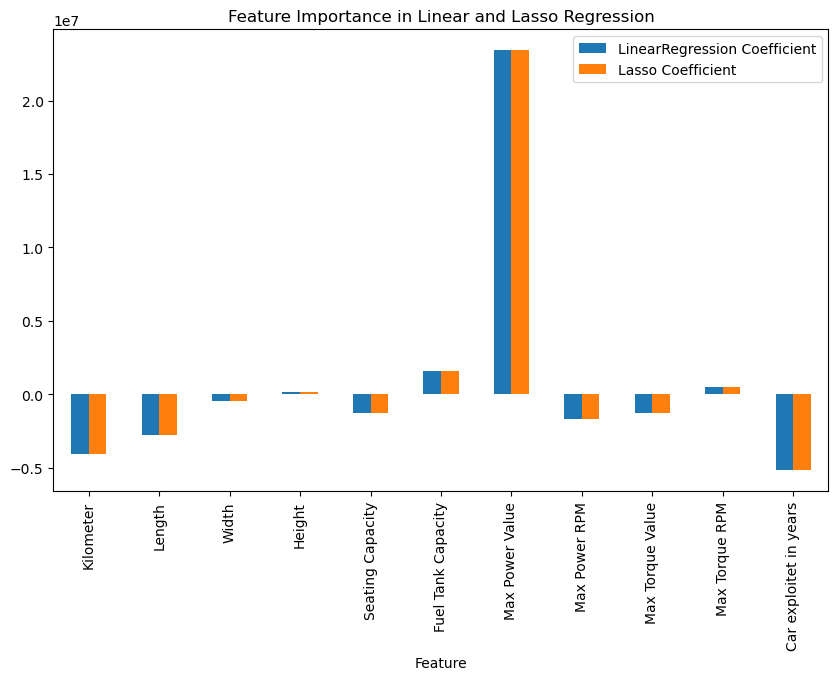

In [322]:
# Hier verwenden wir Xtrain_scaled, Xtest_scaled und y_train, y_test

# Lineares Regressionsmodell
linear_model = LinearRegression()
linear_model.fit(Xtrain_scaled, y_train)

# Lasso-Modell
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(Xtrain_scaled, y_train)

# Koeffizienten für die Modelle extrahieren
linear_coefficients = linear_model.coef_
lasso_coefficients = lasso_model.coef_

# Feature-Namen
feature_names = X.columns

# Erstellen eines DataFrames zur Darstellung der Koeffizienten
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'LinearRegression Coefficient': linear_coefficients,
    'Lasso Coefficient': lasso_coefficients
})

# Anzeigen der Wichtigkeit der Features
print(importance_df)

# Visualisierung der Feature-Wichtigkeit
importance_df.set_index('Feature').plot(kind='bar', figsize=(10, 6), title="Feature Importance in Linear and Lasso Regression")
plt.show()


# object merkmale wieder einfügen

In [323]:
X = df

### Expected Output:
This code performs **One-Hot Encoding** on categorical features in the dataset `X`.

1. **Iterating Through Columns**:
   - The code iterates through each column in the dataset `X` to check if the data type of that column is `object`, indicating it is a categorical feature.

2. **One-Hot Encoding**:
   - For each categorical column, **One-Hot Encoding** is applied using `pd.get_dummies()`. This function converts each unique category within the column into a new binary column (0 or 1), where each new column represents one category.
   
3. **Result**:
   - The dataset `X` is updated with additional columns, where the original categorical features are now split into multiple binary columns (one per category).

4. **Optional Specific Columns**:
   - If you want to apply One-Hot Encoding only to specific columns (e.g., `Fuel Type`, `Transmission`, `Location`), you can define a list of those columns (`columns_to_encode`) and pass them to `pd.get_dummies()`.

In [325]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Iteriere durch alle Spalten
for i in X.columns:
    # Prüfen, ob der Datentyp der Spalte "object" ist (kategorisch)
    if X[i].dtype == 'object':
        # Wende One-Hot-Encoding auf die kategorische Spalte an
        X = pd.get_dummies(X, columns=[i])

# Wenn du es nur auf bestimmte Spalten anwenden willst, kannst du auch explizit definieren:
# columns_to_encode = ['Fuel Type', 'Transmission', 'Location']
# X = pd.get_dummies(X, columns=columns_to_encode)


In [326]:
# One-Hot-Encoding mit Drop der ersten Spalte
X = pd.get_dummies(X, drop_first=True)

In [327]:
y = df["Price"]
X = X.drop(columns=["Price"])

### Expected Output:
In this code, we are training three models (Linear Regression, Logistic Regression, and Lasso) on a dataset, evaluating their performance over 20 iterations, and visualizing the results.

1. **Suppressing Warnings**:
   - The `ConvergenceWarning` from models like Logistic Regression is suppressed using `warnings.filterwarnings("ignore", category=ConvergenceWarning)`. This is useful if convergence warnings clutter the output without adding valuable information.

2. **Data Preprocessing**:
   - The dataset `X` is split into training and test sets 20 times with different random seeds.
   - The features are standardized using `MinMaxScaler`, ensuring that all features have a similar scale for the models to perform better.

3. **Model Initialization and Training**:
   - Three models are initialized: **Linear Regression**, **Logistic Regression** (with a max of 1000 iterations), and **Lasso Regression** (with `alpha=0.1`).
   - The models are trained on the scaled training data (`Xtrain_scaled`, `y_train`) and then used to make predictions on the test data (`Xtest_scaled`).

4. **Model Evaluation**:
   - For each model, the **R² score** is calculated for both the training and test datasets, and the scores are stored in dictionaries (`r2_train_scores` and `r2_test_scores`).

5. **Statistics Calculation**:
   - The mean and standard deviation of the R² scores for each model are calculated to evaluate the overall performance and stability.

6. **Output**:
   - The average R² scores and their standard deviations for each model are printed, showing how well each model performs on both the training and test sets.
   
7. **Visualization**:
   - Two boxplots are generated to visualize the distribution of the R² scores across the 20 iterations. The first boxplot shows the R² scores for the training dataset, and the second one shows the scores for the test dataset.

### What You Will See:
- **Printed Results**: The mean and standard deviation of R² scores for each model on both training and test datasets.
- **Boxplots**: 
  - One for the **training set** R² scores showing the spread and variability across the 20 iterations.
  - One for the **test set** R² scores showing how consistent each model is at generalizing to new data.


Modell: LinearRegression
Durchschnittlicher R²-Score auf dem Trainingsdatensatz: 0.7945347920221131 ± 0.012530043874783674
Durchschnittlicher R²-Score auf dem Testdatensatz: -2.34565075277085e+21 ± 6.213052585297884e+21

Modell: LogisticRegression
Durchschnittlicher R²-Score auf dem Trainingsdatensatz: 0.6678831825277923 ± 0.028084807635327627
Durchschnittlicher R²-Score auf dem Testdatensatz: 0.4158398914398142 ± 0.12199571232250417

Modell: Lasso
Durchschnittlicher R²-Score auf dem Trainingsdatensatz: 0.7945681393707914 ± 0.01252280536709652
Durchschnittlicher R²-Score auf dem Testdatensatz: 0.6983893749203387 ± 0.06949786453769216



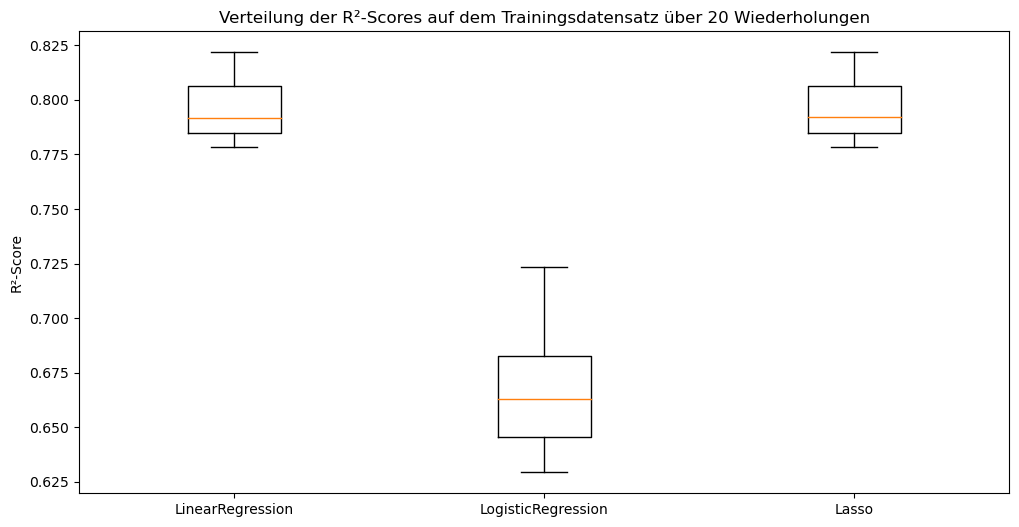

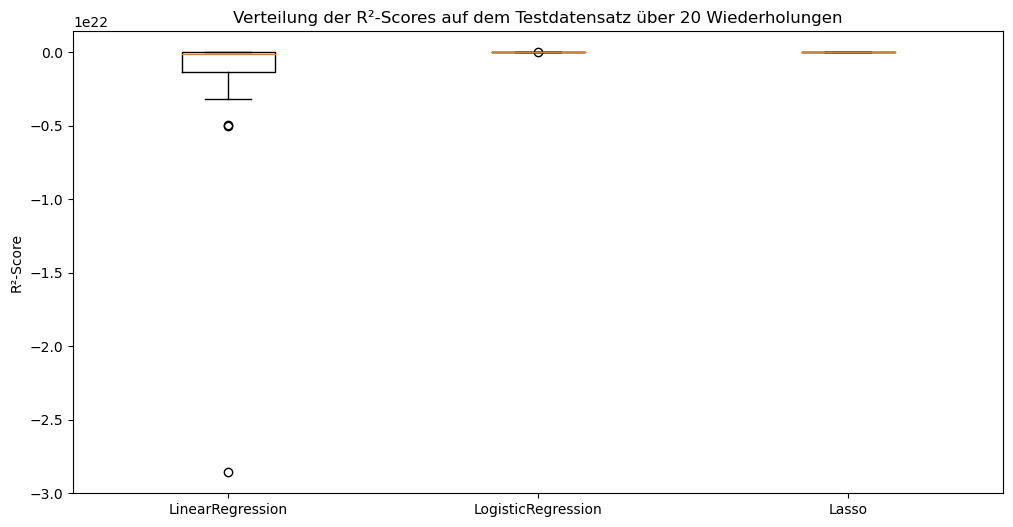

In [328]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Listen zur Speicherung der R²-Scores
r2_train_scores = {"LinearRegression": [], "LogisticRegression": [], "Lasso": []}
r2_test_scores = {"LinearRegression": [], "LogisticRegression": [], "Lasso": []}

# Wiederholen der Schritte 20 Mal
for i in range(20):
    
    
    # Teilen der Daten in Trainings- und Testdatensatz
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Standardisieren der Daten
    scaler = MinMaxScaler()

    # Fit the scaler on Xtrain and transform Xtrain
    Xtrain_scaled = scaler.fit_transform(X_train)

    # Transform Xtest using the same scaler (no fitting)
    Xtest_scaled = scaler.transform(X_test)
    # Initialisierung der Modelle
    models = {
        "LinearRegression": LinearRegression(),
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "Lasso": Lasso(alpha=0.1)
    }

    # Trainieren der Modelle und Vorhersage auf dem Testdatensatz
    for model_name, model in models.items():
        model.fit(Xtrain_scaled, y_train)

        # Vorhersage auf dem Testdatensatz
        ytest_pred = model.predict(Xtest_scaled)

        # Berechnung des R²-Score für den Testdatensatz
        r2_test = r2_score(y_test, ytest_pred)
        r2_test_scores[model_name].append(r2_test)

        # Berechnung des R²-Score für den Trainingsdatensatz
        ytrain_pred = model.predict(Xtrain_scaled)
        r2_train = r2_score(y_train, ytrain_pred)
        r2_train_scores[model_name].append(r2_train)

# Berechnung der Durchschnittswerte und Standardabweichungen
mean_r2_train = {model_name: np.mean(scores) for model_name, scores in r2_train_scores.items()}
std_r2_train = {model_name: np.std(scores) for model_name, scores in r2_train_scores.items()}

mean_r2_test = {model_name: np.mean(scores) for model_name, scores in r2_test_scores.items()}
std_r2_test = {model_name: np.std(scores) for model_name, scores in r2_test_scores.items()}

# Ausgabe der Ergebnisse
for model_name in r2_train_scores.keys():
    print(f"Modell: {model_name}")
    print(f"Durchschnittlicher R²-Score auf dem Trainingsdatensatz: {mean_r2_train[model_name]} ± {std_r2_train[model_name]}")
    print(f"Durchschnittlicher R²-Score auf dem Testdatensatz: {mean_r2_test[model_name]} ± {std_r2_test[model_name]}")
    print()

# Erstellen eines Boxplots zur Visualisierung der Stabilität
plt.figure(figsize=(12, 6))
plt.boxplot([r2_train_scores["LinearRegression"], r2_train_scores["LogisticRegression"], r2_train_scores["Lasso"]],
            labels=['LinearRegression', 'LogisticRegression', 'Lasso'])
plt.title('Verteilung der R²-Scores auf dem Trainingsdatensatz über 20 Wiederholungen')
plt.ylabel('R²-Score')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot([r2_test_scores["LinearRegression"], r2_test_scores["LogisticRegression"], r2_test_scores["Lasso"]],
            labels=['LinearRegression', 'LogisticRegression', 'Lasso'])
plt.title('Verteilung der R²-Scores auf dem Testdatensatz über 20 Wiederholungen')
plt.ylabel('R²-Score')
plt.show()


Train model with RandomForestRegressor

In [329]:
model = RandomForestRegressor()
model.fit(X_no_price, y)  # y is the target variable (Price)

RandomForestRegressor()

## Get feature importances

In [333]:
importances = model.feature_importances_

# Calculate the correlation between features and the target variable (price)
correlations = X_no_price.corrwith(y)

# Create a DataFrame for feature importances and their correlation with price
importance_df = pd.DataFrame({
    'Feature': X_no_price.columns,
    'Importance': model.feature_importances_,
    'Correlation_with_Price': correlations
})

# Sort the importance values in descending order
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted importance values with correlations
sorted_importance_df


,Feature,Importance,Correlation_with_Price
Max Power Value,Max Power Value,6.630656e-01,0.771451
Car exploitet in years,Car exploitet in years,8.615258e-02,-0.311400
Fuel Tank Capacity,Fuel Tank Capacity,6.977321e-02,0.562423
Kilometer,Kilometer,3.817004e-02,-0.150825
Width,Width,3.309636e-02,0.559870
...,...,...,...
Make_Fiat,Make_Fiat,5.710649e-08,-0.018018
Fuel Type_CNG + CNG,Fuel Type_CNG + CNG,3.202846e-08,-0.013248
Fuel Type_Petrol + LPG,Fuel Type_Petrol + LPG,3.084711e-08,-0.014332
Color_Pink,Color_Pink,2.256258e-08,-0.014287


Correlation_with_Price column exists.


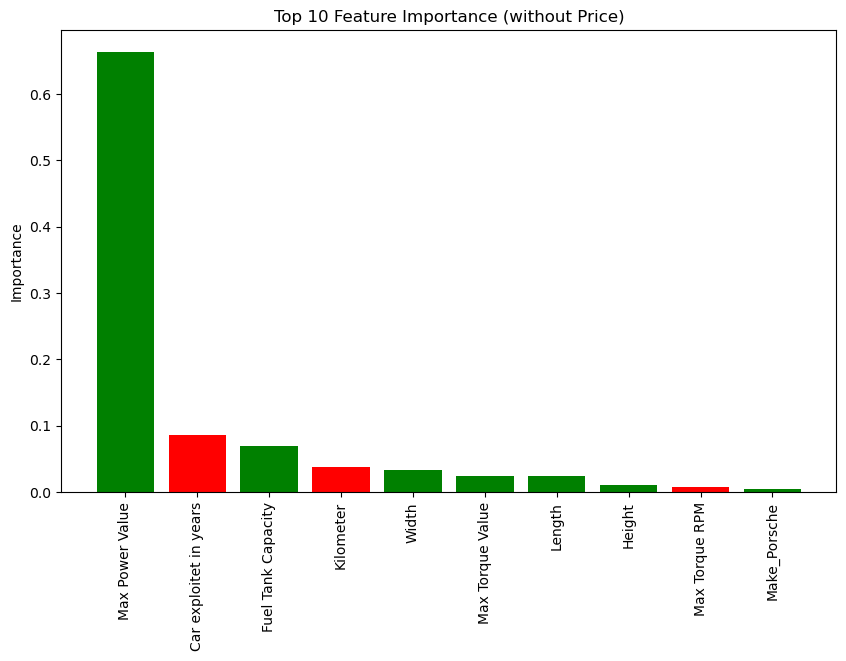

In [335]:
# Select top 10 features by importance
top_10_features = sorted_importance_df.head(10).copy()  # Use copy() to avoid SettingWithCopyWarning

# Check if the 'Correlation_with_Price' column exists and is numeric
if 'Correlation_with_Price' in top_10_features.columns:
    print("Correlation_with_Price column exists.")

    # Create a color map based on correlation values: Green for positive, Red for negative
    top_10_features['Color'] = top_10_features['Correlation_with_Price'].apply(lambda x: 'green' if x > 0 else 'red')

    # Plot the top 10 features with the color based on correlation
    plt.figure(figsize=(10, 6))
    bars = plt.bar(top_10_features['Feature'], top_10_features['Importance'], color=top_10_features['Color'])

    # Title and labels
    plt.title("Top 10 Feature Importance (without Price)")
    plt.ylabel("Importance")
    plt.xticks(rotation=90)  # Rotate feature names for better visibility

    # Show plot
    plt.show()
else:
    print("'Correlation_with_Price' column is missing.")


### Fazit:

In this analysis of feature importance for car pricing, the results reveal some insightful patterns that offer a deeper understanding of the factors influencing a car’s price. The **Max Power Value** stands out as the most influential feature in determining the price, emphasizing the critical role that a car's performance—specifically, its power—plays in the market. This could reflect consumer preferences for more powerful vehicles, which often translate into higher demand and, consequently, higher prices.

Conversely, certain factors, such as the **year of exploitation** and **kilometer count**, exhibit a clear negative correlation with price. As the car ages and accumulates more kilometers, its market value tends to decrease. This is consistent with general market behavior, where older cars and those with higher mileage are often seen as less reliable, leading to lower valuations.

Additionally, it’s noteworthy that **features such as fuel type, transmission, and location** have their own distinct impacts on price, which may be influenced by regional preferences and economic factors. For instance, cars with certain fuel types may be more attractive in specific regions due to environmental regulations or fuel costs.

The visualization also suggests that while performance-related features are paramount, the depreciation of a car over time—evidenced by its age and usage—has a profound impact on its valuation. This insight can help sellers, buyers, and automotive industry experts make more informed decisions, aligning market expectations with real-world pricing dynamics.

### Conclusion:
The analysis underscores a balance between performance and longevity in car pricing. While high performance can command higher prices, the inevitable depreciation with age and usage cannot be ignored. This finding emphasizes the importance of considering both the car's condition and its intrinsic features when evaluating its market value. As we move towards a more data-driven future, understanding these relationships will be key in shaping pricing strategies and consumer preferences within the automotive industry.
